# **2024 ML FALL HW1: PM2.5 Prediction (Regression)**

Author: MLTAs

Methods:
* Training with all data
* Optimizer: RMSProp
* TODO:
 - Change the "valid" function and the "train_config"
 - Implement 2nd-order polynomial regression model (without interaction terms)



# **Import Some Packages**

In [408]:
import numpy as np
import csv
import math
import pandas as pd
import os

# **Fix random seed**


This is for the reproduction of your result. **DO NOT modify this secton!**


In [409]:
seed = 9487
np.random.seed(seed)

# **Download training data**


In [410]:
!gdown --id "1Hfzrcm69QwdFvdeF0uASoQlcVxKw_hHy" --output "train.csv"
!gdown --id '155N6fzI7vAFzHAGdy6jkaWIksWH6Y1G2' --output "test.csv"

# Incase the links above die, you can use the following instead.
#!gdown --id '11abE854Eyv4BA7qt5k8r_80sJ3KuOQUN' --output "train.csv"
#!gdown --id '1uod-Z4ztluXnuHtgUbm39nMudUKqXHMl' --output "test.csv"

# If the data is still missing, you can manually download it from kaggle, and upload the files under /content

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Hfzrcm69QwdFvdeF0uASoQlcVxKw_hHy
To: /content/train.csv
100% 324k/324k [00:00<00:00, 17.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=155N6fzI7vAFzHAGdy6jkaWIksWH6Y1G2
To: /content/test.csv
100% 49.0k/49.0k [00:00<00:00, 77.9MB/s]


In [411]:
def valid(x, y, feats):
  # TODO: Try to filter out extreme values.
  #  ex: If PM2.5 > 100, then we don't use the data to train (return False), otherwise return True,
  if (y > 22): # Q90 of y
    return False
  if (2 in feats): # NO
    index = feats.index(2)
    if any(x[index] > 20):
      return False
  # if (3 in feats): # NO2
  #   index = feats.index(3)
  #   if any(x[index] > 35):
  #     return False
  # if (6 in feats): # PM10
  #   index = feats.index(6)
  #   if any(x[index] > 200):
  #     return False
  # if (8 in feats): # RAINFALL
  #   index = feats.index(8)
  #   if any(x[index] > 40):
  #     return False
  if (10 in feats): # SO2
    index = feats.index(10)
    if any(x[index] > 50):
      return False
  if (11 in feats): # WD_HR
    index = feats.index(11)
    if any(x[index] > 340):
      return False
  # if (13 in feats): # WINDSPEED
  #   index = feats.index(13)
  #   if any(x[index] > 10):
  #     return False

  return True


# Create your dataset
def parse2train(data, feats):

  x = []
  y = []

  # Use data #0~#7 to predict #8 => Total data length should be decresased by 8.
  total_length = data.shape[1] - 8

  for i in range(total_length):
    x_tmp = data[feats, i:i+8] # Use data #0~#7 to predict #8, data #1~#8 to predict #9, etc.
    y_tmp = data[-1, i+8] # last column of (i+8)th row: PM2.5
    # x_tmp 8x8
    # Filter out extreme values to train.
    if valid(x_tmp, y_tmp, feats):
      x.append(x_tmp.reshape(-1,))
      y.append(y_tmp)

  # x.shape: (n, m_feats, 8)
  # y.shape: (n, 1)
  x = np.array(x)
  y = np.array(y)

  return x,y


#**RMSProp**
* This is our gradient descent algorithm. RMSProp was implemented.
* You can implement another algorithm such as SGD, which may (or may not) boost the performance.
* However, **modules like sklearn and pytorch are not allowed**.
* Ref:
 - G. Hinton's lecture: https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
 - figure: https://miro.medium.com/v2/resize:fit:1366/format:webp/0*n5V-NxsJJhgFYG8b

![](https://miro.medium.com/v2/resize:fit:1366/format:webp/0*n5V-NxsJJhgFYG8b)



In [412]:
def minibatch(x, y, config):
    # Randomize the data in minibatch
    index = np.arange(x.shape[0])
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    # Initialization
    batch_size = config.batch_size
    lr = config.lr
    lam = config.lam
    epoch = config.epoch
    decay_rate = config.decay_rate
    epsilon = 1e-8

    # Linear regression: only contains two parameters (w, b).
    w = np.full(x[0].shape, 0.1).reshape(-1, 1) # to column
    bias = 0.1

    # Optimizer states
    cache_w = np.zeros_like(w)
    cache_b = 0.0
    momen_w = np.zeros_like(w)
    momen_b = 0.0

    # Training loop
    for num in range(epoch):
        for b in range(int(x.shape[0] / batch_size)):
            x_batch = x[b * batch_size:(b + 1) * batch_size]
            y_batch = y[b * batch_size:(b + 1) * batch_size].reshape(-1, 1)

            # Prediction of linear regression
            pred = np.dot(x_batch, w) + bias

            # Loss
            loss = y_batch - pred

            # Compute gradient
            g_t = np.dot(x_batch.transpose(), loss) * (-2)
            g_t_b = loss.sum(axis=0) * (-2)

            # Update cache
            cache_w = decay_rate * cache_w + (1 - decay_rate) * g_t**2
            cache_b = decay_rate * cache_b + (1 - decay_rate) * g_t_b**2

            # Update weight & bias
            update_w = lr * g_t / (np.sqrt(cache_w) + epsilon) - momen_w
            update_b = lr * g_t_b / (np.sqrt(cache_b) + epsilon) - momen_b
            w -= update_w
            bias -= update_b

            # Update Momentum
            momen_w = lam * update_w
            momen_b = lam * update_b
    return w, bias

# TODO: Implement 2-nd polynomial regression version for the report.
def minibatch_2(x, y, config):
    # Randomize the data in minibatch
    index = np.arange(x.shape[0])
    np.random.shuffle(index)
    x = x[index]
    x2 = np.square(x[index]) # 2nd order term
    y = y[index]

    # Initialization
    batch_size = config.batch_size
    lr = config.lr
    lam = config.lam
    epoch = config.epoch
    decay_rate = config.decay_rate
    epsilon = 1e-8

    # Linear regression: only contains two parameters (w, b).
    # reshape w to m x 1 column
    w = np.full(x[0].shape, 0.1).reshape(-1, 1)
    w2 = np.full(x[0].shape, 0.1).reshape(-1, 1) # 2nd order
    bias = 0.1

    # Optimizer states
    cache_w = np.zeros_like(w)
    cache_w2 = np.zeros_like(w2)
    cache_b = 0.0

    # Training loop
    for num in range(epoch):
        for b in range(int(x.shape[0] / batch_size)):
            x_batch = x[b * batch_size:(b + 1) * batch_size]
            x2_batch = x2[b * batch_size:(b + 1) * batch_size] # m x 1 x n
            y_batch = y[b * batch_size:(b + 1) * batch_size].reshape(-1, 1)

            # Prediction of linear regression
            pred = np.dot(x_batch, w) + np.dot(x2_batch, w2) + bias

            # Loss
            loss = y_batch - pred

            # Compute gradient
            g_t = np.dot(x_batch.transpose(), loss) * (-2) # 1 x m
            g_t_x2 = np.dot(x2_batch.transpose(), loss) * (-2) # 1 x m
            g_t_b = loss.sum(axis=0) * (-2)

            # Update cache
            cache_w = decay_rate * cache_w + (1 - decay_rate) * g_t**2
            cache_w2 = decay_rate * cache_w2 + (1 - decay_rate) * g_t_x2**2
            cache_b = decay_rate * cache_b + (1 - decay_rate) * g_t_b**2

            # Update weight & bias
            w -= lr * g_t / (np.sqrt(cache_w) + epsilon)
            w2 -= lr * g_t_x2 / (np.sqrt(cache_w2) + epsilon)
            bias -= lr * g_t_b / (np.sqrt(cache_b) + epsilon)

    return w, w2, bias

In [413]:
from argparse import Namespace

# TODO: Tune the config to boost your performance.
train_config = Namespace(
    batch_size = 128, # default 256
    lr = 0.03, # learning rate: eta default 0.1
    lam = 0.002,
    epoch = 4, #3
    decay_rate = 0.9 # default 0.9
)

# **Training your regression model**

In [414]:
data = pd.read_csv("/content/train.csv")
data.head()

,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,WS_HR,RAINFALL,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,PM2.5
0,10.8,0.32,1.7,8.6,10.3,22.9,21,0.6,0.0,71,1.9,172,171,0.6,15
1,10.8,0.27,1.6,6.2,7.8,23.8,20,1.4,0.0,71,1.7,161,129,1.8,13
2,11.0,0.25,0.9,5.4,6.3,27.4,21,0.8,0.0,68,1.6,152,147,1.5,12
3,11.0,0.23,0.7,3.1,3.8,29.5,21,1.8,0.0,68,1.6,138,145,1.7,9
4,11.3,0.22,0.8,2.9,3.8,30.7,16,1.9,0.0,67,1.6,140,139,1.7,9


### EDA: boxplot
As a reference for filtering extreme data.

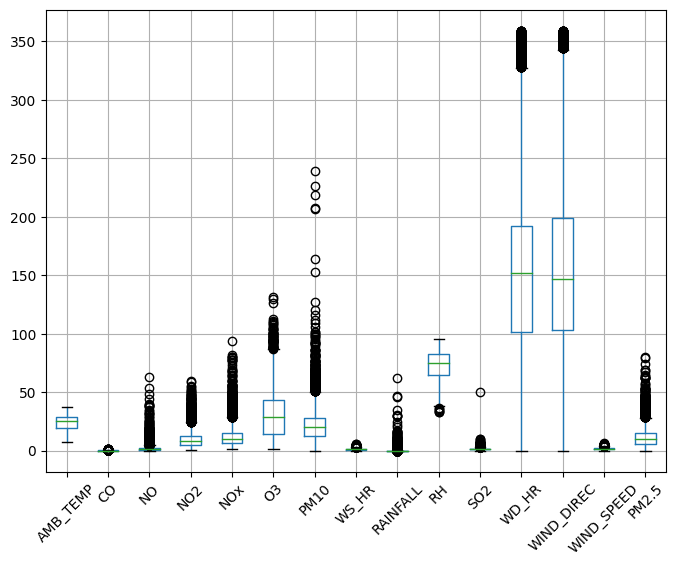

In [415]:
# EDA: boxplot
import matplotlib.pyplot as plt

data.boxplot(column=list(data.columns), figsize=(8,6), rot = 45)
plt.show()

Some randomly selected features

In [416]:
# Choose your features to train.
# Hint:
# 1. You can select more than one feature.
# 2. You should select "good" features.

# TODO: Carefully justify which feature should be chosen.
feat_names = list(data.keys())
print(feat_names)
selected_feat = ['CO', 'NO', 'NO2']
feats = [feat_names.index(element) for element in selected_feat]
print(feats)
print(len(feats))

['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'WS_HR', 'RAINFALL', 'RH', 'SO2', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'PM2.5']
[1, 2, 3]
3


In [417]:
def training(data, feats, train_config, return_train_data = True):
    # Training data preprocessing.
    new_data = data.values
    train_data = np.transpose(np.array(np.float64(new_data)))
    train_x, train_y = parse2train(train_data, feats)
    # Train your regression model
    w, bias = minibatch(train_x, train_y, train_config)
    if return_train_data:
      return w, bias, train_x, train_y
    else:
      return w, bias

In [418]:
# training RMSE
def RMSE(w, bias, x, y):
  # print(w.shape, bias.shape, x.shape, y.shape)
  N = int(x.shape[0])
  result = 0
  for i in range(N):
    # Prediction of linear regression
    prediction = (np.dot(np.reshape(w,-1), x[i]) + bias)[0]
    error = prediction - y[i]
    result += (error)**2
    # if abs(error) > 100:
    #   weird.append(i)
  result = math.sqrt(result/N)
  return result
# print(f"Selected Features: {selected_feat}\nTrain RMSE = {RMSE(w, bias, train_x, train_y)}")

## Feature Selection
Using backward selection method,
 greedly removed the features that cause greatest reduction in Training RMSE, until RMSE doesn't reduce more.

Note that since greedy policy does not ganruntee the optimal solution, and the batching involves randomness, the results may be not so consistent.

In [419]:
def backward_selection(data, train_config):
    ## Supported by gemini
    feat_names = list(data.keys())
    selected_features = list(range(len(feat_names)))
    best_rmse = -1
    current_rmse = -1
    while len(selected_features) > 1:
        # Try removing one feature at a time
        for feature in selected_features:
            # Remove Feature
            temp_features = selected_features.copy()
            temp_features.remove(feature)

            # Train and evaluate with the temporary feature set
            for times in range(3):
              w, bias, train_x, train_y = training(data, temp_features, train_config)
              if times == 0:
                temp_rmse = RMSE(w, bias, train_x, train_y)
              else:
                temp_rmse = temp_rmse + RMSE(w, bias, train_x, train_y)
            temp_rmse = temp_rmse / 3

            # Update if improvement found
            if ((best_rmse == -1) | (temp_rmse < best_rmse)):
                best_rmse = temp_rmse
                best_features = temp_features.copy()

        # Check if there was an improvement
        if ((current_rmse == -1) | (best_rmse < current_rmse)):
            current_rmse = best_rmse
            selected_features = best_features.copy()
            print(f"Removed feature, RMSE improved to: {current_rmse}, features: {selected_features}")
        else:
            break  # No improvement, stop the process

    return selected_features, best_rmse

In [420]:
# seed = 9487
# np.random.seed(seed)
# data = pd.read_csv("/content/train.csv")
# selected_features, best_rmse = backward_selection(data, train_config)
# print(f"Features: {list(feat_names[i] for i in selected_features)},\n Train RMSE: {best_rmse}")

After many trial and error, select PM2.5 alone seems to be the best strategy.

In [421]:
seed = 9487
np.random.seed(seed)
selected_feat = ['PM2.5']
selected_features = [feat_names.index(element) for element in selected_feat]
print(f'Backward: {selected_features}')
data = pd.read_csv("/content/train.csv")
rmse_bw = -1
for i in range(100):
  w_tmp, bias_tmp, train_x, train_y = training(data, selected_features, train_config)
  if (i == 1): print(train_y.shape)
  rmse_tmp = RMSE(w_tmp, bias_tmp, train_x, train_y)
  if rmse_tmp<3.0: print(f'{i}_Backward_RMSE: {rmse_tmp}')
  if ((rmse_bw == -1)|(rmse_bw > rmse_tmp)):
    rmse_bw = rmse_tmp
    w_backward = w_tmp
    bias_backward = bias_tmp
  else:
    pass

Backward: [14]
(5212,)
9_Backward_RMSE: 2.9538113324457185
12_Backward_RMSE: 2.954174001981789
13_Backward_RMSE: 2.986931389980606
15_Backward_RMSE: 2.9644919336542377
17_Backward_RMSE: 2.9656871459377263
20_Backward_RMSE: 2.9635043984525105
22_Backward_RMSE: 2.993716180868738
24_Backward_RMSE: 2.9652225243488988
27_Backward_RMSE: 2.9884188069620197
30_Backward_RMSE: 2.952864462514466
31_Backward_RMSE: 2.9831705310401224
33_Backward_RMSE: 2.999470113783968
41_Backward_RMSE: 2.958505949836189
53_Backward_RMSE: 2.9655045487465563
58_Backward_RMSE: 2.9757836113867877
60_Backward_RMSE: 2.9657468435974255
62_Backward_RMSE: 2.985192653373643
63_Backward_RMSE: 2.966989797354968
76_Backward_RMSE: 2.9781527407248496
78_Backward_RMSE: 2.9751588559247644
79_Backward_RMSE: 2.9908485168096126
84_Backward_RMSE: 2.9905438105764603
87_Backward_RMSE: 2.9585250913470964


# **Testing:**


In [422]:
def parse2test(data, feats):
  x = []
  for i in range(90):
    x_tmp = data[feats,8*i: 8*i+8]
    x.append(x_tmp.reshape(-1,))

  # x.shape: (n, 15, 8)
  x = np.array(x)
  return x

In [423]:
data = pd.read_csv('test.csv')
# print(data)
new_data = data.values

test_data = np.transpose(np.array(np.float64(new_data)))
test_x = parse2test(test_data, selected_features)

# **Write result as .csv**

---



In [424]:
with open('my_sol_backward.csv', 'w', newline='') as csvf:
    writer = csv.writer(csvf)
    writer.writerow(['Id','Predicted'])
    print(test_x.shape)
    for i in range(int(test_x.shape[0])):
      # Prediction of linear regression
      prediction = (np.dot(np.reshape(w_backward,-1),test_x[i]) + bias_backward)[0]
      writer.writerow([i, prediction])

(90, 8)


# Linear Regression with 2nd order polynomial

In [425]:
selected_feat = ['NO']
feats = [feat_names.index(element) for element in selected_feat]
print(len(feats))
# Training data preprocessing.
data = pd.read_csv("/content/train.csv")
data = data.values
train_data = np.transpose(np.array(np.float64(data)))
train_x, train_y = parse2train(train_data, feats)
train_x2 = np.square(train_x)
print(train_x.shape, train_x2.shape)

1
(5129, 8) (5129, 8)


In [426]:
train_x2.shape

(5129, 8)

In [427]:
## Training 2nd order polynomial
w, w2, bias = minibatch_2(train_x, train_y, train_config)
print(w.shape, w2.shape, bias.shape)
print(f'Parameter estimates of 2nd order polynomial with parameter `NO` only:')
print(f'1st order weights:\n{w.reshape(1,-1)},\n2nd order weights:\n{w2.reshape(1,-1)}')
print(f'Bias: {bias}')

(8, 1) (8, 1) (1,)
Parameter estimates of 2nd order polynomial with parameter `NO` only:
1st order weights:
[[0.46530873 0.20428631 0.22506219 0.24768373 0.34223948 0.09673192
  0.23798201 0.51302962]],
2nd order weights:
[[ 0.02155248  0.01761945  0.02655412  0.00644438 -0.01976931  0.03580375
  -0.00605293  0.02644598]]
Bias: [3.69722655]


In [428]:
train_y.shape

(5129,)

In [429]:
# RMSE training of 2nd_poly
RMSE = 0
train_N = int(train_x.shape[0])
# weird = []
for i in range(train_N):
  # Prediction of linear regression
  prediction = (np.dot(np.reshape(w,-1), train_x[i])+
          np.dot(np.reshape(w2,-1), train_x2[i])+
                 bias)[0]
  error = prediction - train_y[i]
  RMSE += (error)**2
  # if abs(error) > 100:
  #   weird.append(i)
RMSE = math.sqrt(RMSE/train_N)
print(f'Train RMSE = {RMSE}')

Train RMSE = 6.35963439423078


## Testing and Results for 2nd ploynminal

In [430]:
def parse2test_2(data, feats):
  x = []
  x2 = []
  for i in range(90):
    x_tmp = data[feats,8*i: 8*i+8]
    x2_tmp = np.square(x_tmp)
    x.append(x_tmp.reshape(-1,))
    x2.append(x2_tmp.reshape(-1,))

  # x.shape: (n, 15, 8)
  x = np.array(x)
  x2 = np.array(x2)
  return x, x2

In [431]:
data = pd.read_csv('test.csv')
# print(data)
data = data.values
test_data = np.transpose(np.array(np.float64(data)))
test_x, test_x2 = parse2test_2(test_data, feats)

In [432]:
with open('my_sol_2.csv', 'w', newline='') as csvf:
    writer = csv.writer(csvf)
    writer.writerow(['Id','Predicted'])
    print(test_x.shape, test_x2.shape)
    for i in range(int(test_x.shape[0])):
      # Prediction of linear regression
      prediction = (np.dot(np.reshape(w,-1),test_x[i])+
                    np.dot(np.reshape(w2,-1),test_x2[i])+
                    bias)[0]
      writer.writerow([i, prediction])

(90, 8) (90, 8)
